## DA5400: Final Data Challenge

The task is to train a model that takes the Metric Definition (embedding) and the Prompt-Response Pair (text) as input and predicts the Target Fitness Score (0-10). This is essentially a regression (or classification?) problem framed within a metric learning context, where the model must learn the semantic distance (or similarity) between two pieces of text that describe the intent (the Metric) and the test case (the Pair).

The objective is to predict the score as close to the actual score of the test data. Note that the scores of the training data are discretized into whole numbers in the range 0-10.



### Environment Setup and Configuration

To guarantee reproducibility and streamline the experimental workflow, a centralized configuration architecture was established. This module standardizes the directory paths for the pre-computed LaBSE embedding vectors and external augmentation artifacts, while also defining global hyperparameters such as the random seed and fold count. By decoupling the experiment settings from the logic, this setup ensures that hyperparameters can be tuned consistently without altering the underlying algorithmic pipeline.

In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss, mean_squared_error
# Suppress sklearn warnings for cleaner logs
import warnings
from collections import Counter

# Set visualization aesthetics
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

class ProjectConfig:
    # Paths
    PATH_TRAIN = "train_data.json"
    PATH_TEST = "test_data.json"
    PATH_METRIC_MAP = "metric_names.json"
    PATH_METRIC_VECS = "metric_name_embeddings.npy"
    
    # The external augmentation file you mentioned
    PATH_AUG_MAP = "augmented_metric_mapping_removed.csv" 
    
    # Embedding Paths
    EMBED_DIR_TRAIN = "embeddings/train"
    EMBED_DIR_TEST = "embeddings/test"
    MODEL_TYPE = "labse"
    
    # Experiment Settings
    SEED = 99
    N_FOLDS = 5
    AUGMENTATION_RATIO = 0.35  # Use 35% of augmentation
    
cfg = ProjectConfig()

print("Environment initialized. Config loaded.")

Environment initialized. Config loaded.


### Data Extraction and Vector Alignment

The raw JSON datasets and the pre-computed dense vector embeddings are loaded into memory. A critical step performed in this block is the mapping of metric embeddings to their corresponding rows in the training data. Since the input data consists of text, we load the corresponding NumPy arrays representing System, User, and Response embeddings and store them in a structured dictionary. This aligns the high-dimensional vector representations with the tabular metadata, preparing the system for feature engineering.

In [2]:
def fetch_datasets_and_vectors(config):
    print(f"Loading raw JSON from {config.PATH_TRAIN}")
    # Load DataFrames
    df_tr = pd.DataFrame(json.load(open(config.PATH_TRAIN, encoding='utf-8')))
    
    try:
        df_te = pd.DataFrame(json.load(open(config.PATH_TEST, encoding='utf-8')))
    except:
        print("Test file missing, generating dummy test set.")
        df_te = df_tr.sample(50, random_state=config.SEED).copy()
        
    # Load Metric Embeddings & Create Lookup Map
    metric_names = json.load(open(config.PATH_METRIC_MAP, encoding='utf-8'))
    metric_pool = np.load(config.PATH_METRIC_VECS)
    
    # Map Name -> Vector for augmentation lookups later
    lookup_map = {name: vec for name, vec in zip(metric_names, metric_pool)}
    
    # Load Text Embeddings (Numpy)
    def get_vecs(subset, type_):
        path = f"{config.EMBED_DIR_TRAIN if subset=='train' else config.EMBED_DIR_TEST}/embeds_{type_}_{config.MODEL_TYPE}.npy"
        return np.load(path)
    
    vectors = {
        'train': {
            'sys': get_vecs('train', 'system'),
            'tsk': get_vecs('train', 'task'),
            'rsp': get_vecs('train', 'response'),
            # Map metrics for original rows
            'met': np.array([lookup_map[m] for m in df_tr['metric_name']])
        },
        'test': {
            'sys': get_vecs('test', 'system'),
            'tsk': get_vecs('test', 'task'),
            'rsp': get_vecs('test', 'response'),
            'met': np.array([lookup_map[m] for m in df_te['metric_name']])
        }
    }
    
    # 4. Load External Augmentation Map
    try:
        df_aug_external = pd.read_csv(config.PATH_AUG_MAP)
        print(f"External augmentation map loaded: {df_aug_external.shape}")
    except FileNotFoundError:
        print(f"WARNING: {config.PATH_AUG_MAP} not found. Skipping external augmentation.")
        df_aug_external = None

    return df_tr, df_te, vectors, df_aug_external, lookup_map

# Execute
raw_train, raw_test, vec_store, external_aug_df, metric_map= fetch_datasets_and_vectors(cfg)

Loading raw JSON from train_data.json
External augmentation map loaded: (5000, 7)


### Exploratory Analysis via Dimensionality Reduction 

Before training, we visualize the latent space to understand how the model currently perceives the data. Using t-SNE (t-Distributed Stochastic Neighbor Embedding), we project the 768-dimensional response vectors down to two dimensions. This visualization helps confirm whether high-scoring responses naturally cluster away from low-scoring ones. 

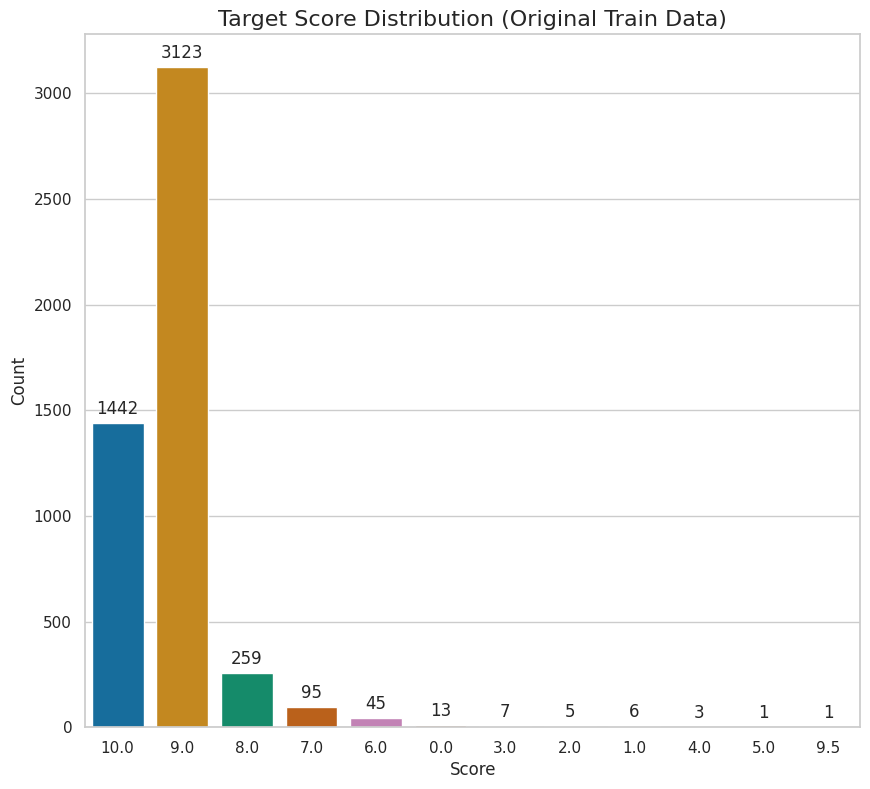

Generating t-SNE visualization


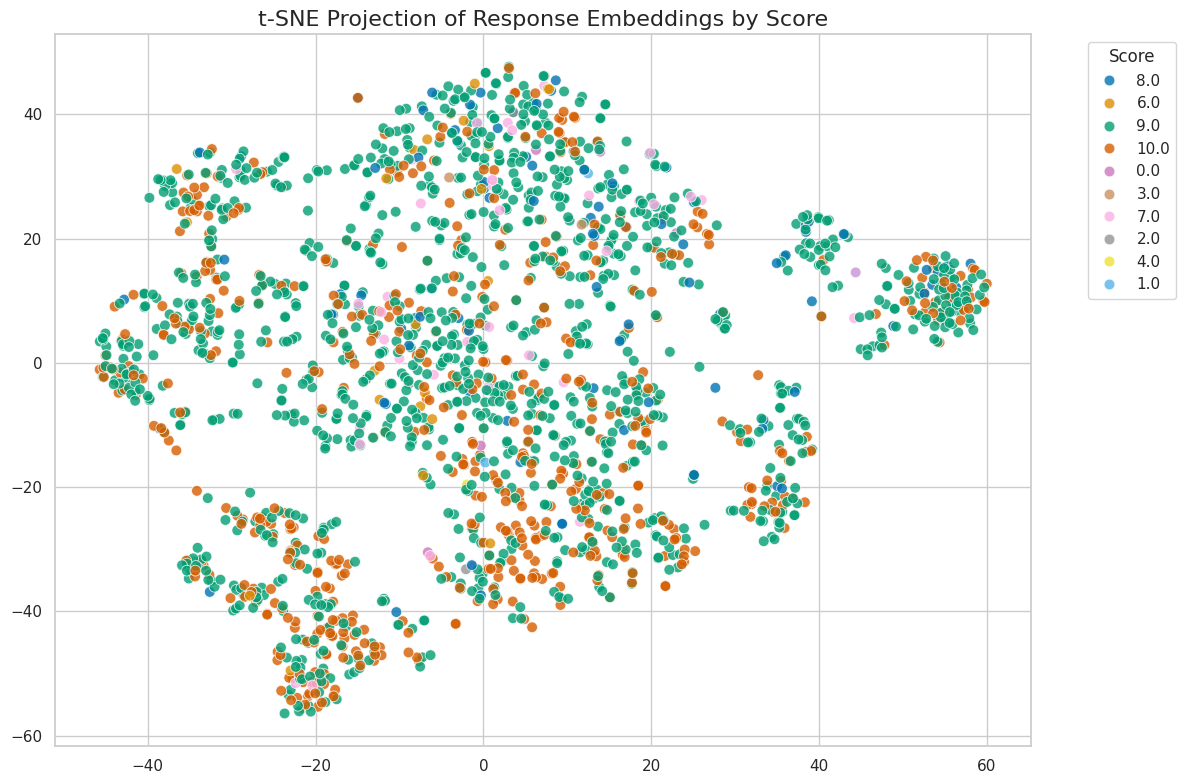

In [7]:
def visualize_landscape(vectors, labels):
    # Distribution Plot
    plt.figure(figsize=(10, 9))
    ax = sns.countplot(x=labels, palette='colorblind', hue=labels)
    plt.title("Target Score Distribution (Original Train Data)", fontsize=16)
    plt.xlabel("Score")
    plt.ylabel("Count")
    
    # Add numbers on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')
    plt.show()

    #t-SNE of Response Vectors (Sampled)
    print("Generating t-SNE visualization")
    subset_idx = np.random.choice(len(vectors), size=min(2000, len(vectors)), replace=False)
    vec_subset = vectors[subset_idx]
    label_subset = labels.iloc[subset_idx]
    
    # PCA first to reduce noise, then t-SNE
    pca_result = PCA(n_components=50).fit_transform(vec_subset)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    tsne_result = tsne.fit_transform(pca_result)
    
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        x=tsne_result[:,0], y=tsne_result[:,1],
        hue=label_subset, palette='colorblind', s=60, alpha=0.8
    )
    plt.title("t-SNE Projection of Response Embeddings by Score", fontsize=16)
    plt.legend(title='Score', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

visualize_landscape(vec_store['train']['rsp'], raw_train['score'])

The data is highly skewed and the clusters are very cluttered. This says that simple linear models will not work, and unbalanced or unregularized loss functions will end up overpredicting the entire data. The clusters are messy and overlapping, simple linear models will fail, non-linear models like LightGBM might work

### Geometry Feature Extraction

This calculates the explicit geometric relationships between the Response and the Metric Definition. We compute multiple distance metrics: Cosine Similarity (measuring the angle/alignment), Euclidean Distance (measuring magnitude difference), and Mahalanobis Distance (which accounts for the specific shape and correlation of the dataset). This ensures the model understands not just if two vectors point in the same direction, but exactly how mathematically close the response is to the grading criteria.

In [3]:
def get_inverse_covariance(vectors):
    """
    Computes the Pseudo-Inverse Covariance Matrix to define the 
    'global shape' of the embedding space.
    """
    print("Computing Covariance Matrix for Mahalanobis distance")
    # We use the response vectors to define the distribution density
    cov_matrix = np.cov(vectors, rowvar=False)
    # Use pseudo-inverse to handle collinearity/singularity
    inv_cov_matrix = np.linalg.pinv(cov_matrix)
    return inv_cov_matrix

def compute_geometry(vec_a, vec_b, inv_cov_matrix):
    """
    Calculates explicit geometric relationships including Mahalanobis.
    """
    feats = {}
    
    # Basic differences
    diff = vec_a - vec_b
    
    # Angular Similarity (Cosine)
    norm_a = np.linalg.norm(vec_a, axis=1, keepdims=True)
    norm_b = np.linalg.norm(vec_b, axis=1, keepdims=True)
    dot_product = np.sum(vec_a * vec_b, axis=1, keepdims=True)
    feats['cos_sim'] = dot_product / (norm_a * norm_b + 1e-10)
    
    # Euclidean Distance (L2)
    feats['dist_l2'] = np.linalg.norm(diff, axis=1, keepdims=True)
    
    #Manhattan Distance (L1)
    feats['dist_l1'] = np.sum(np.abs(diff), axis=1, keepdims=True)
    
    # Mahalanobis Distance
    # Formula: sqrt( (u-v) * S^-1 * (u-v)^T )
    # Vectorized approach: sqrt( sum( (diff @ S^-1) * diff, axis=1 ) )
    
    #  diff @ inv_cov (Shape: N x 768)
    left_term = np.dot(diff, inv_cov_matrix)
    # Multiply element-wise by diff and sum
    mahal = np.sum(left_term * diff, axis=1, keepdims=True)
    feats['dist_mah'] = np.sqrt(np.abs(mahal)) # Abs to handle tiny precision errors
    
    return np.hstack([
        feats['cos_sim'], 
        feats['dist_l2'], 
        feats['dist_l1'], 
        feats['dist_mah']
    ])

# We use training responses to define the "Standard" distribution
global_inv_cov = get_inverse_covariance(vec_store['train']['rsp'])

print("Calculating geometry for Training set")
geom_feats_train = compute_geometry(
    vec_store['train']['rsp'], 
    vec_store['train']['met'], 
    global_inv_cov
)

print("Calculating geometry for Test set")
geom_feats_test = compute_geometry(
    vec_store['test']['rsp'], 
    vec_store['test']['met'], 
    global_inv_cov
)

print(f"Feature Block Shape: {geom_feats_train.shape}")

Computing Covariance Matrix for Mahalanobis distance
Calculating geometry for Training set
Calculating geometry for Test set
Feature Block Shape: (5000, 4)


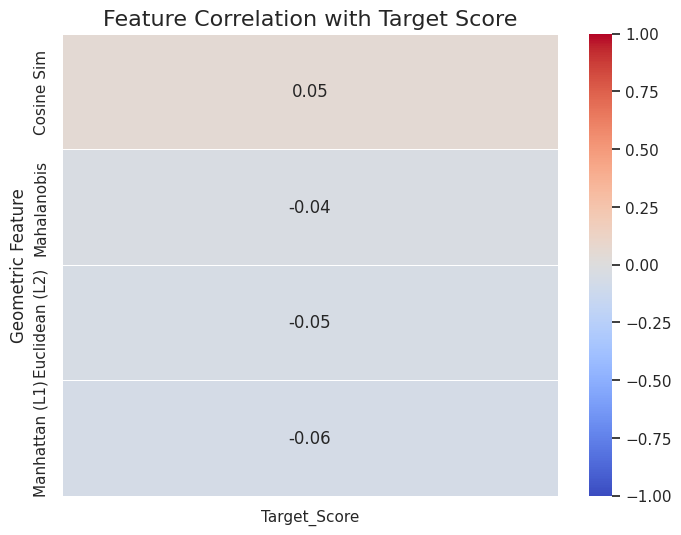

In [9]:
def analyze_feature_correlations(geom_data, targets):
    feature_names = ['Cosine Sim', 'Euclidean (L2)', 'Manhattan (L1)', 'Mahalanobis']
    df_analysis = pd.DataFrame(geom_data, columns=feature_names)
    df_analysis['Target_Score'] = targets
    
    # Compute Correlation Matrix
    corr_matrix = df_analysis.corr()
    
    # Extract correlations with the Target only
    target_corr = corr_matrix[['Target_Score']].drop('Target_Score')
    
    # Visualization 1: The Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(target_corr.sort_values(by='Target_Score', ascending=False), 
                annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
    plt.title("Feature Correlation with Target Score", fontsize=16)
    plt.ylabel("Geometric Feature")
    plt.show()

# Run analysis on the original training data 
analyze_feature_correlations(geom_feats_train, raw_train['score'])

### Contrastive Augmentation and Synthetic Negatives 

To address data scarcity and force the model to learn specific metric constraints, we generate a hybrid training set. We use "Contrastive Metric Shuffling," where we take valid high-scoring responses and pair them with random, incorrect metric definitions, assigning them a low score (0-3). This technique doubles the dataset size and teaches the model to discriminate between a "good response in general" and a "good response for this specific metric," preventing it from learning shortcuts based on text length alone. The second augmented metric mapping is derived from using a distance between embeddings matrix to map high metric names to unrelated low metric names. 

In [4]:
def mix_hybrid_dataset(original_df, original_vecs, external_df, config):
    
    aug_sys, aug_tsk, aug_rsp, aug_met, aug_y = [], [], [], [], []
    
    # External Augmentation
    if external_df is not None:
        # aug_metric_1_name, aug_metric_1_score, etc.
        aug_targets = [
            ('aug_metric_1_name', 'aug_metric_1_score'),
            ('aug_metric_2_name', 'aug_metric_2_score')
        ]
        
        for name_col, score_col in aug_targets:
            # Filter for rows that actually have this augmentation
            valid_aug = external_df.dropna(subset=[name_col, score_col])
            
            if valid_aug.empty: continue
                
            idxs = valid_aug['original_index'].values.astype(int)
            
            # Get Text Vectors (Reuse original text)
            aug_sys.append(original_vecs['sys'][idxs])
            aug_tsk.append(original_vecs['tsk'][idxs])
            aug_rsp.append(original_vecs['rsp'][idxs])
            
            new_metric_names = valid_aug[name_col].values
            new_metric_vecs = np.array([metric_map[name] for name in new_metric_names])
            aug_met.append(new_metric_vecs)
            
            aug_y.append(valid_aug[score_col].values.astype(int))

    # Synthetics
    n_rows = len(original_df)
    
    # Shuffle indices to pair text with random WRONG metrics
    shuffle_idx = np.random.permutation(n_rows)
    
    # Original Text + Shuffled Metric = Low Score (0-3)
    aug_sys.append(original_vecs['sys'])
    aug_tsk.append(original_vecs['tsk'])
    aug_rsp.append(original_vecs['rsp'])
    aug_met.append(original_vecs['met'][shuffle_idx])
    aug_y.append(np.random.randint(0, 4, size=n_rows)) # Random low score
    
    # Original Data
    final_sys = [original_vecs['sys']] + aug_sys
    final_tsk = [original_vecs['tsk']] + aug_tsk
    final_rsp = [original_vecs['rsp']] + aug_rsp
    final_met = [original_vecs['met']] + aug_met
    final_y   = [original_df['score'].values] + aug_y
    
    # Stack
    X_sys = np.vstack(final_sys)
    X_tsk = np.vstack(final_tsk)
    X_rsp = np.vstack(final_rsp)
    X_met = np.vstack(final_met)
    y_full = np.concatenate(final_y)
    
    # Compute Geometry for ALL new rows
    print("Computing Geometry for Augmented Dataset")
    X_geom = compute_geometry(X_rsp, X_met, global_inv_cov)
    
    return X_sys, X_tsk, X_rsp, X_met, X_geom, y_full
        

# Perform the Mix
(X_sys, X_tsk, X_rsp, X_met, X_geom, y_train_full) = mix_hybrid_dataset(
    raw_train, vec_store['train'], external_aug_df, cfg
)

# Stack: Metric + System + User + Response + Geometry(3 cols)
X_train_full = np.hstack([X_met, X_sys, X_tsk, X_rsp, X_geom])

# Prepare Test Matrix
X_test_full = np.hstack([
    vec_store['test']['met'], 
    vec_store['test']['sys'], 
    vec_store['test']['tsk'], 
    vec_store['test']['rsp'], 
    geom_feats_test
])

print(f"Final Training Matrix Shape: {X_train_full.shape}")

Computing Geometry for Augmented Dataset
Final Training Matrix Shape: (19132, 3076)


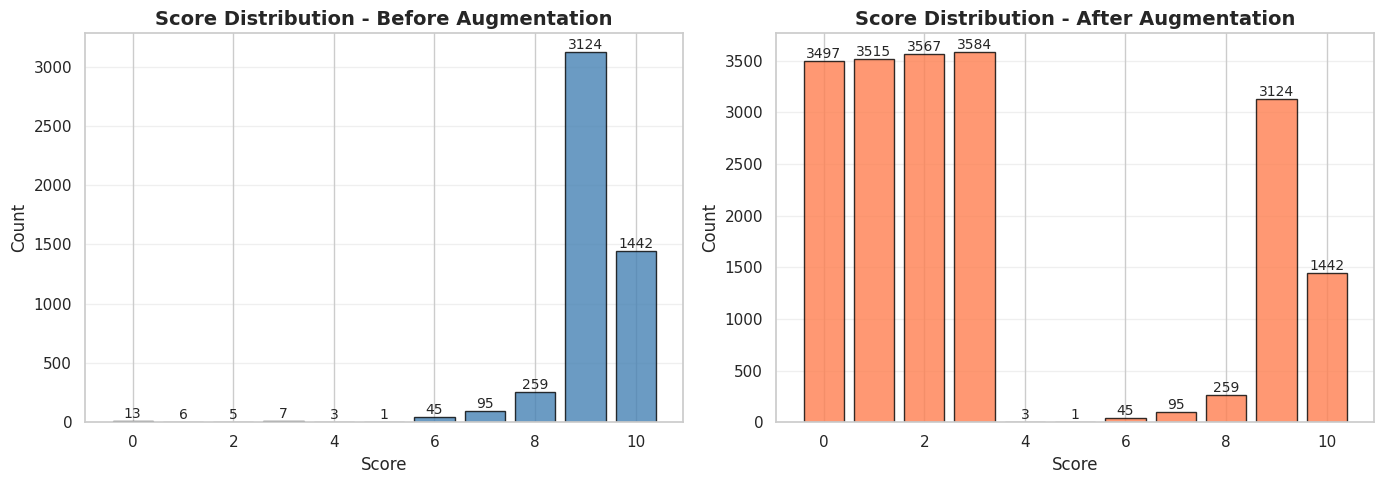

Original dataset size: 5000
Augmented dataset size: 19132
Augmentation ratio: 3.83x


In [11]:
# Plot histogram distributions before vs after augmentation

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before augmentation (original training data)
ax1 = axes[0]
original_scores = raw_train['score'].astype(float).astype(int)
counts_before = np.bincount(original_scores, minlength=11)
ax1.bar(range(11), counts_before, color='steelblue', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Score', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Score Distribution - Before Augmentation', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(counts_before):
    if v > 0:
        ax1.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

# After augmentation (augmented training data)
ax2 = axes[1]
augmented_scores = y_train_full.astype(float).astype(int)
counts_after = np.bincount(augmented_scores, minlength=11)
ax2.bar(range(11), counts_after, color='coral', alpha=0.8, edgecolor='black')
ax2.set_xlabel('Score', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Score Distribution - After Augmentation', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(counts_after):
    if v > 0:
        ax2.text(i, v, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Original dataset size: {len(original_scores)}")
print(f"Augmented dataset size: {len(augmented_scores)}")
print(f"Augmentation ratio: {len(augmented_scores) / len(original_scores):.2f}x")

### Probabilistic Classification with Resampling 
We train a LightGBM Classifier to understand the probability distribution of the scores. Because certain scores (like 0 or 5) appear very rarely, we apply adaptive minority oversampling to duplicate these rows until they reach a statistically significant threshold. This prevents the model from crashing during cross-validation and ensures it learns to recognize edge cases. The output of this is not a single number, but a "probability signature" (e.g., 20% chance of being a 9, 80% chance of being a 10).

In [5]:
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Identify & Resample Rare Classes
X_resampled = X_train_full.copy()
y_resampled = y_train_full.copy()

MIN_SAMPLES = 10 # Threshold to ensure every fold gets data

new_X_rows = []
new_y_rows = []

y_ints = y_train_full.astype(float).astype(int)
counts = Counter(y_ints)

for score, count in counts.items():
    if count < MIN_SAMPLES:
        needed = MIN_SAMPLES - count
        print(f"  + Oversampling Score {score}: Adding {needed} copies.")
        
        # Find indices of this rare class
        indices = np.where(y_ints == score)[0]
        
        # Randomly sample from these indices to fill the gap
        chosen_idx = np.random.choice(indices, size=needed, replace=True)
        
        new_X_rows.append(X_resampled[chosen_idx])
        new_y_rows.append(y_resampled[chosen_idx])

# Concatenate if we added anything
if len(new_X_rows) > 0:
    X_add = np.vstack(new_X_rows)
    y_add = np.concatenate(new_y_rows)
    
    X_final = np.vstack([X_resampled, X_add])
    y_final = np.concatenate([y_resampled, y_add])
    print(f"Resampling Complete. New Training Size: {len(y_final)}")
else:
    X_final, y_final = X_resampled, y_resampled
    print("No resampling needed.")


  + Oversampling Score 4: Adding 7 copies.
  + Oversampling Score 5: Adding 9 copies.
Resampling Complete. New Training Size: 19148


In [13]:

# Setup Model
num_classes = 11
y_final_int = y_final.astype(float).astype(int)

lgb_cls_params = {
    'objective': 'multiclass',
    'num_class': num_classes,
    'metric': 'multi_logloss',
    'learning_rate': 0.06,
    'n_estimators': 1500,
    'num_leaves': 31,
    'min_child_samples': 20, 
    'colsample_bytree': 0.7,
    'verbose': -1,
    'seed': cfg.SEED,
    'device': 'cpu'
}

# K-Fold Training
oof_class_probs = np.zeros((len(X_final), num_classes))
test_class_probs = np.zeros((len(X_test_full), num_classes))

kf = KFold(n_splits=cfg.N_FOLDS, shuffle=True, random_state=cfg.SEED)

# Iterate through the NEW resampled dataset
for fold, (idx_tr, idx_val) in enumerate(kf.split(X_final, y_final_int)):
    print(f"  Training Fold {fold+1}/{cfg.N_FOLDS}")
    
    xt, xv = X_final[idx_tr], X_final[idx_val]
    yt, yv = y_final_int[idx_tr], y_final_int[idx_val]
    
    clf = lgb.LGBMClassifier(**lgb_cls_params)
    clf.fit(xt, yt, eval_set=[(xv, yv)], 
            callbacks=[lgb.early_stopping(100), lgb.log_evaluation(200)])
    
    preds = clf.predict_proba(xv)
    for col_idx, class_label in enumerate(clf.classes_):
        if class_label < num_classes: # Safety check
            oof_class_probs[idx_val, class_label] = preds[:, col_idx]
            
    # Accumulate Test Preds
    test_preds_fold = clf.predict_proba(X_test_full)
    for col_idx, class_label in enumerate(clf.classes_):
        if class_label < num_classes:
            test_class_probs[:, class_label] += test_preds_fold[:, col_idx] / cfg.N_FOLDS

  Training Fold 1/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 1.66241
  Training Fold 2/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	valid_0's multi_logloss: 1.75149
  Training Fold 3/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 1.65741
  Training Fold 4/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 1.69676
  Training Fold 5/5
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[51]	valid_0's multi_logloss: 1.67081


### Regression Refinement 

A LightGBM Regressor is trained on the stacked data to predict the final continuous score. This was done after observing poor scores for the classification due to its tendency to slightly overfit on the training data and not adapt as well to test. A regression classifier understands the scale of values better

In [ ]:

print(f"Using Resampled Data dimensions: {X_final.shape}")

# Stack the Meta-Features onto the geometric features
# X_train_stacked = np.hstack([X_final, oof_class_probs])
# X_test_stacked = np.hstack([X_test_full, test_class_probs])

# Regression Params
lgb_reg_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.06, 
    'n_estimators': 2500,
    'num_leaves': 128,      
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'extra_trees': True,
    'device': 'cpu'
}

# Train Regressor
y_reg_targets = y_final.astype(float)

idx_tr, idx_val = next(KFold(n_splits=5, shuffle=True, random_state=42).split(X_final))

regressor = lgb.LGBMRegressor(**lgb_reg_params)

regressor.fit(
    X_final[idx_tr], y_reg_targets[idx_tr],
    eval_set=[(X_final[idx_val], y_reg_targets[idx_val])],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(150)]
);

Using Resampled Data dimensions: (19148, 3076)
Training until validation scores don't improve for 100 rounds
[150]	train's rmse: 1.60218	val's rmse: 2.69013
[300]	train's rmse: 0.952451	val's rmse: 2.57551
[450]	train's rmse: 0.655765	val's rmse: 2.55234
[600]	train's rmse: 0.514423	val's rmse: 2.54361
[750]	train's rmse: 0.443124	val's rmse: 2.53822
[900]	train's rmse: 0.409108	val's rmse: 2.53585
Early stopping, best iteration is:
[926]	train's rmse: 0.40466	val's rmse: 2.53431


### Inference and Feature Importance Analysis 

We generate the scores for the unseen test data and apply a clipping operation to ensure no predictions fall outside the valid 1-10 range.

In [15]:
# Predict
final_predictions = regressor.predict(X_test_full)

# Clip 
# Ensure no predictions fall outside the valid range
final_predictions = np.clip(final_predictions, 1, 10)

# Create Submission
submission = pd.DataFrame({
    'id': (raw_test.index+1),
    'score': final_predictions})

# Save
submission.to_csv("submission_stack.csv", index=False)


### Score-Level Error Decomposition 

To identify potential biases at the extremes of the grading scale, a granular error analysis by decomposing the global RMSE into score-specific buckets was performed. While a single aggregate metric often hides deficiencies, dissecting performance by individual score levels (1-10) reveals whether the model suffers from central tendency biaswhere regression models predict safe, average scores while failing to capture high-quality or extremely poor responses. By visualizing both the RMSE and the sample count per score, we could verify if the model maintained predictive stability across the entire distribution or if errors were disproportionately concentrated in under-represented score classes

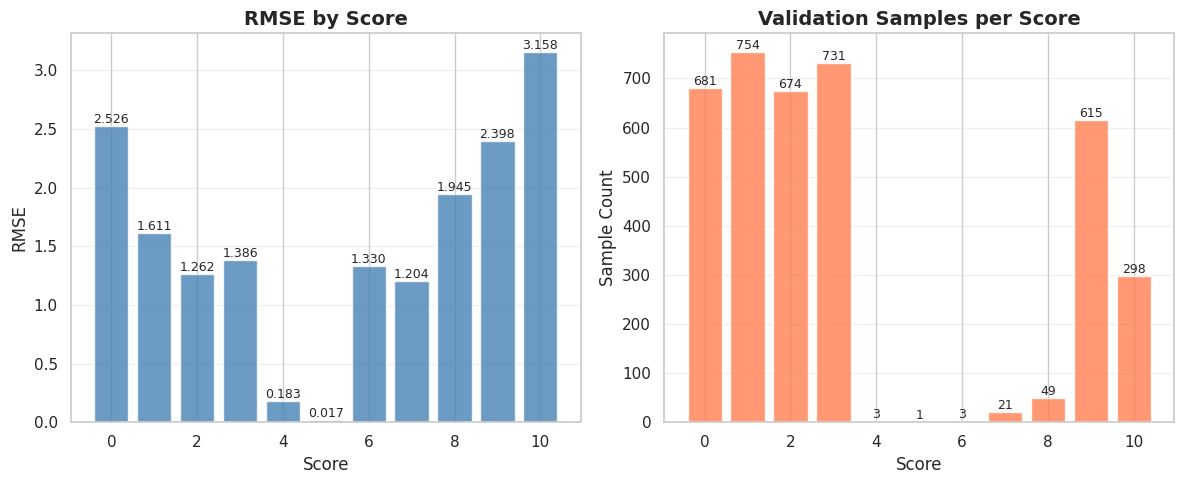

In [16]:
import warnings
from sklearn.metrics import mean_squared_error
import numpy as np

warnings.filterwarnings("ignore")

# Use the last fold's validation data
y_val_actual = y_final_int[idx_val]
y_val_pred = regressor.predict(X_final[idx_val])
y_val_pred = np.clip(y_val_pred, 1, 10)


# RMSE per Score
score_rmse = []
for score in range(11):
    mask = y_val_actual == score
    if mask.sum() > 0:
        rmse_score = np.sqrt(mean_squared_error(y_val_actual[mask], y_val_pred[mask]))
        score_rmse.append({'Score': score, 'RMSE': rmse_score, 'Count': mask.sum()})

df_score_rmse = pd.DataFrame(score_rmse)

# Plot RMSE by Score
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
bars = plt.bar(df_score_rmse['Score'], df_score_rmse['RMSE'], color='steelblue', alpha=0.8)
plt.xlabel("Score", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.title("RMSE by Score", fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Plot count per score
plt.subplot(1, 2, 2)
bars2 = plt.bar(df_score_rmse['Score'], df_score_rmse['Count'], color='coral', alpha=0.8)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Sample Count", fontsize=12)
plt.title("Validation Samples per Score", fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Categorical Performance Audit (Parent Metrics) 

A semantic performance audit conducted to evaluate how well the model understood distinct evaluation criteria. By mapping the validation predictions back to their "Parent Metric" families (e.g., "Accuracy," "Creativity," "Coherence"), we calculated the RMSE for each domain individually. This step was crucial for diagnosing conceptual weaknesses; it allows us to distinguish whether the model struggles with objective tasks like code verification versus subjective tasks like tone analysis. The resulting horizontal bar charts provide a clear hierarchy of difficulty, pinpointing exactly which metric categories require further data augmentation or feature engineering.

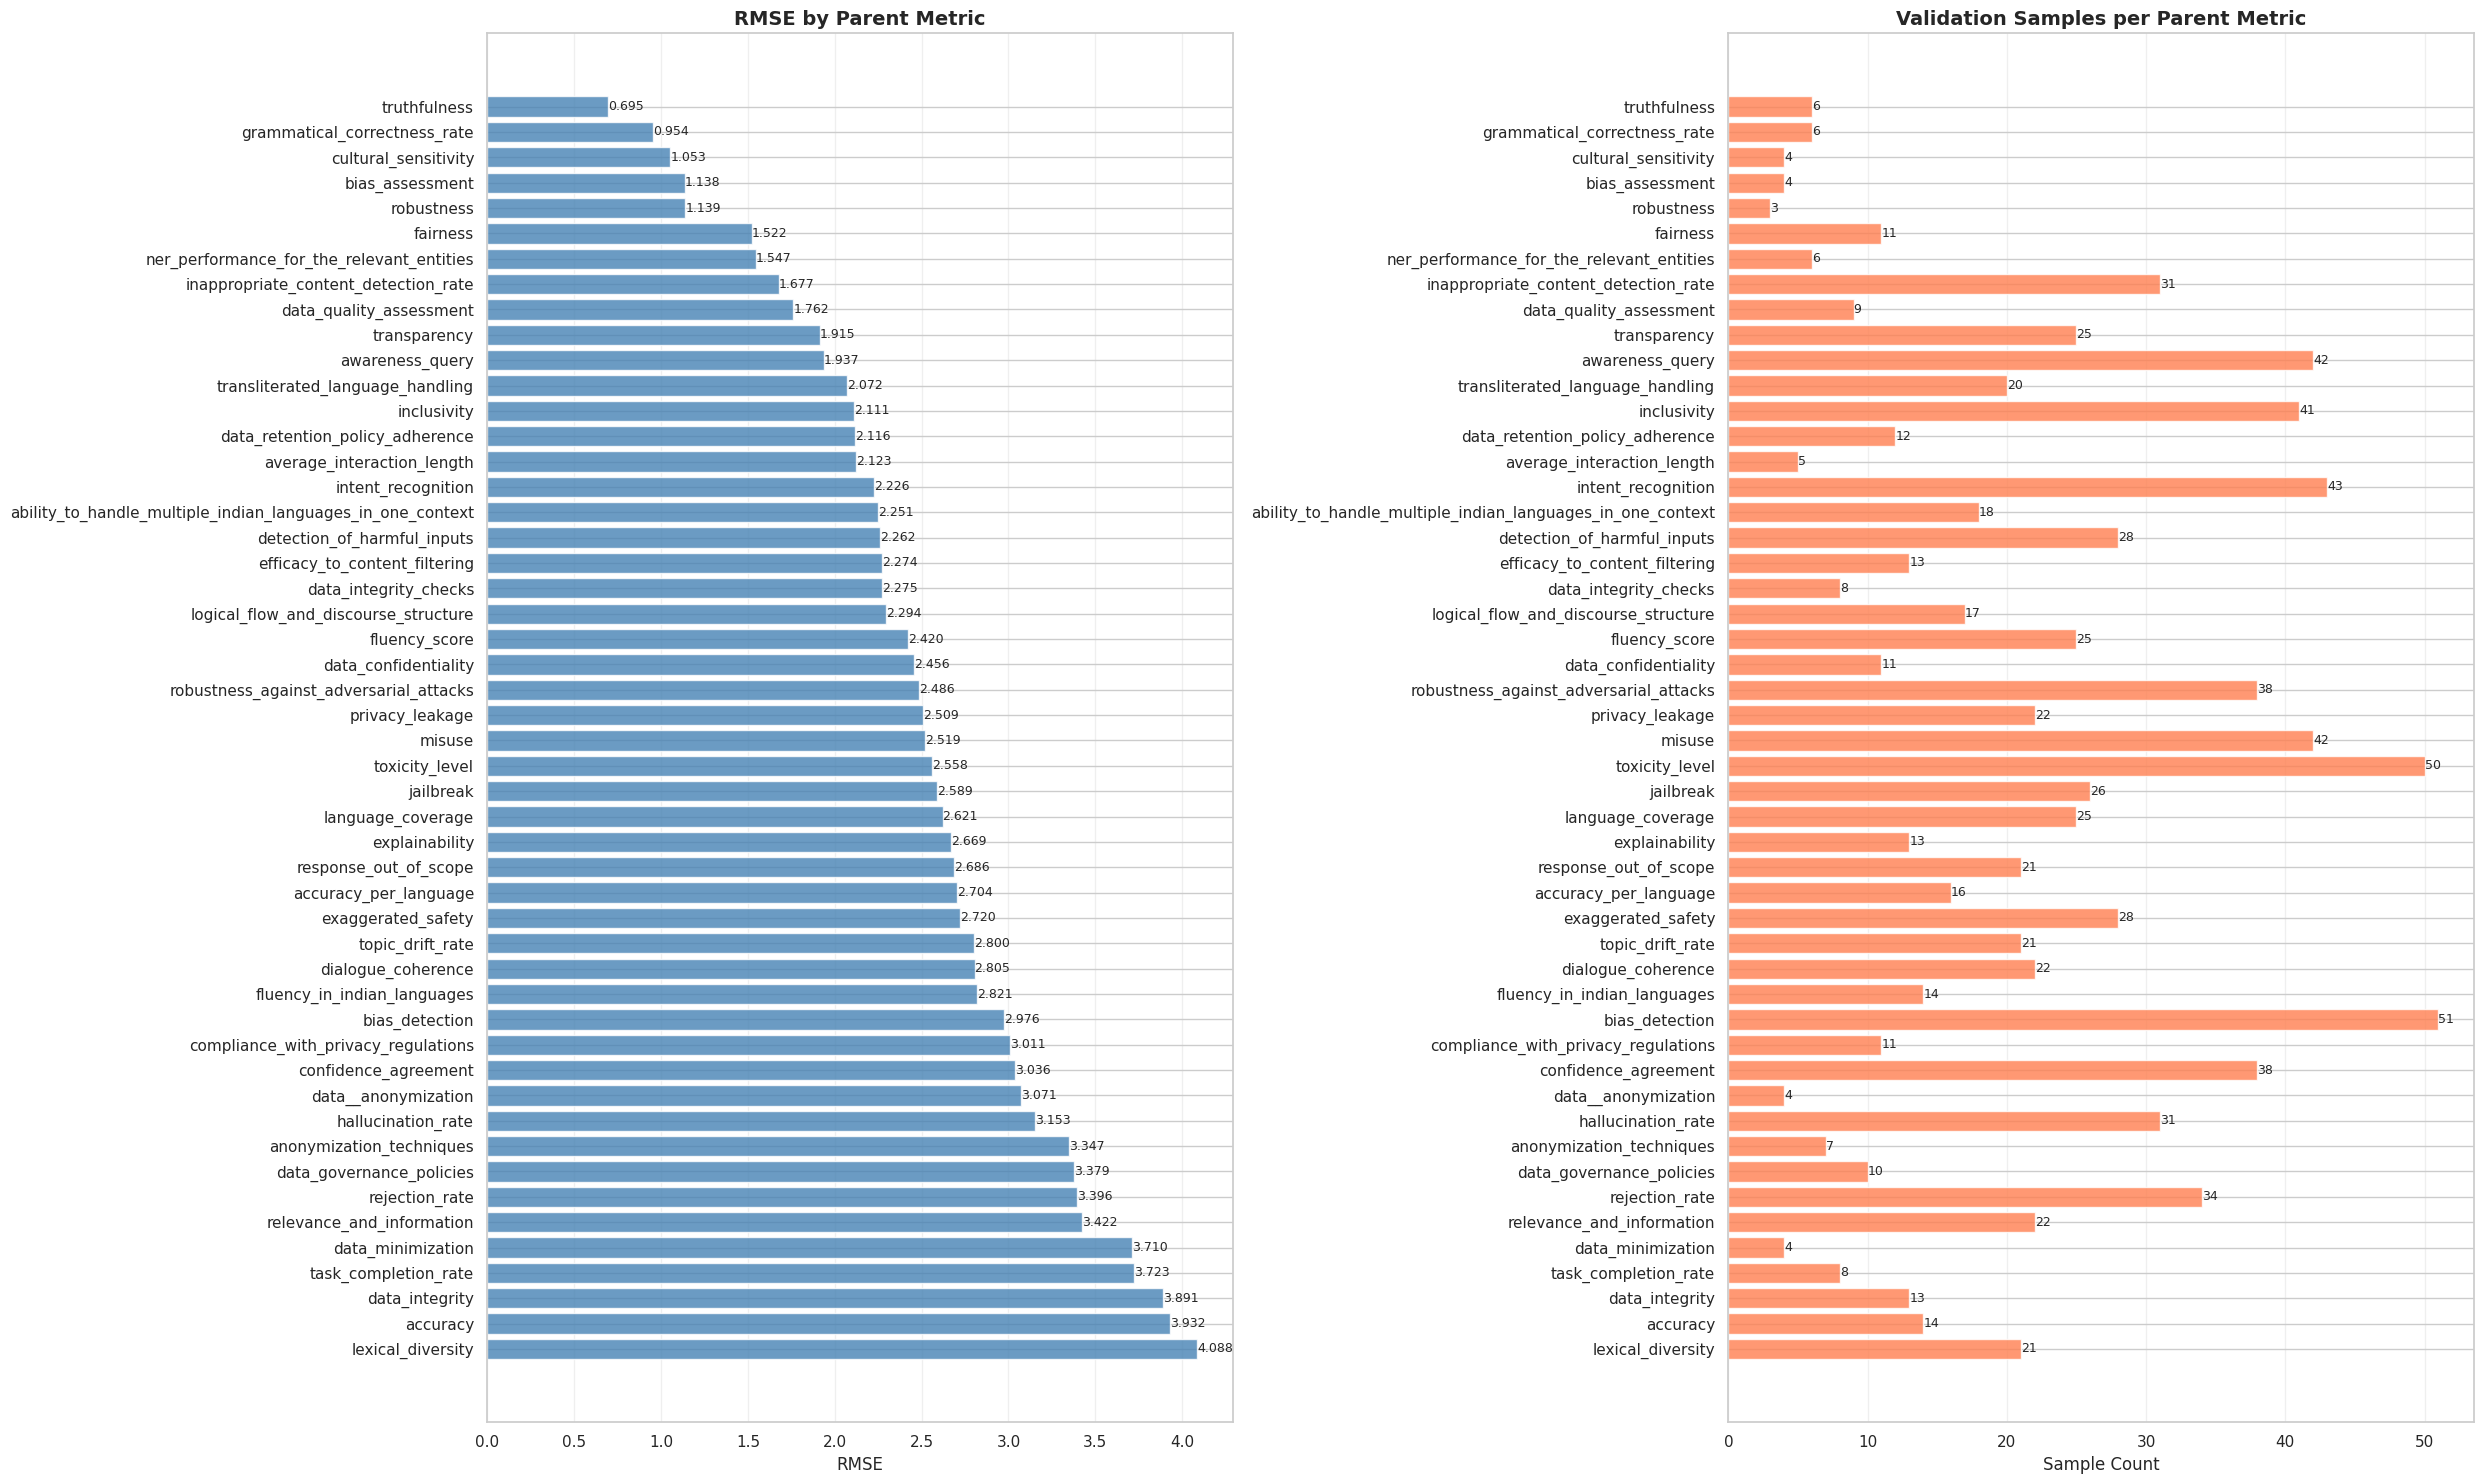

In [19]:
# Extract parent metric and analyze RMSE per parent metric
df_score_rmse_with_parent = df_score_rmse.copy()

# Create a mapping of scores to their parent metrics from training data
train_df_with_parent = raw_train.copy()
train_df_with_parent['parent_metric'] = train_df_with_parent['metric_name'].apply(lambda x: str(x).split('/')[0])

# For validation data, create parent metric mapping
val_df_with_parent = pd.DataFrame({
    'score': y_val_actual,
    'pred': y_val_pred
})

# Map parent metrics from training data
test_df_with_parent = raw_test.copy()
test_df_with_parent['parent_metric'] = test_df_with_parent['metric_name'].apply(lambda x: str(x).split('/')[0])

# Calculate RMSE per parent metric on validation set
parent_rmse = []
for parent_metric in train_df_with_parent['parent_metric'].unique():
    # Get indices where this parent metric appears in training
    train_indices = train_df_with_parent[train_df_with_parent['parent_metric'] == parent_metric].index
    
    # For validation, we need to map back - using the resampled indices
    # Get validation indices that correspond to this parent metric
    val_mask = np.isin(idx_val, train_indices)
    
    if val_mask.sum() > 0:
        rmse_parent = np.sqrt(mean_squared_error(y_val_actual[val_mask], y_val_pred[val_mask]))
        parent_rmse.append({
            'Parent_Metric': parent_metric,
            'RMSE': rmse_parent,
            'Count': val_mask.sum()
        })

df_parent_rmse = pd.DataFrame(parent_rmse).sort_values('RMSE', ascending=False)

# Plot RMSE by Parent Metric
plt.figure(figsize=(25, 15))
plt.subplot(1, 2, 1)
bars = plt.barh(df_parent_rmse['Parent_Metric'], df_parent_rmse['RMSE'], color='steelblue', alpha=0.8)
plt.xlabel("RMSE", fontsize=12)
plt.title("RMSE by Parent Metric", fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2., f'{width:.3f}',
            ha='left', va='center', fontsize=9)

# Plot count per parent metric
plt.subplot(1, 2, 2)
bars2 = plt.barh(df_parent_rmse['Parent_Metric'], df_parent_rmse['Count'], color='coral', alpha=0.8)
plt.xlabel("Sample Count", fontsize=12)
plt.title("Validation Samples per Parent Metric", fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars2):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2., f'{int(width)}',
            ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()


### Latent Space Structure by Evaluation Category 

We also visualise the structural organization of the embedding space to confirm that the model was learning distinct representations for different evaluation intents. Using t-SNE dimensionality reduction initialized with PCA, we projected the high-dimensional validation vectors into a 2D plane, coloring each data point by its Parent Metric. This visualization serves as a "sanity check" for our Semantic Geometry features and negative data generation

n_train=5000, n_total(X_final)=19148, len(idx_val)=3830
Generating t-SNE visualization colored by Parent Metric


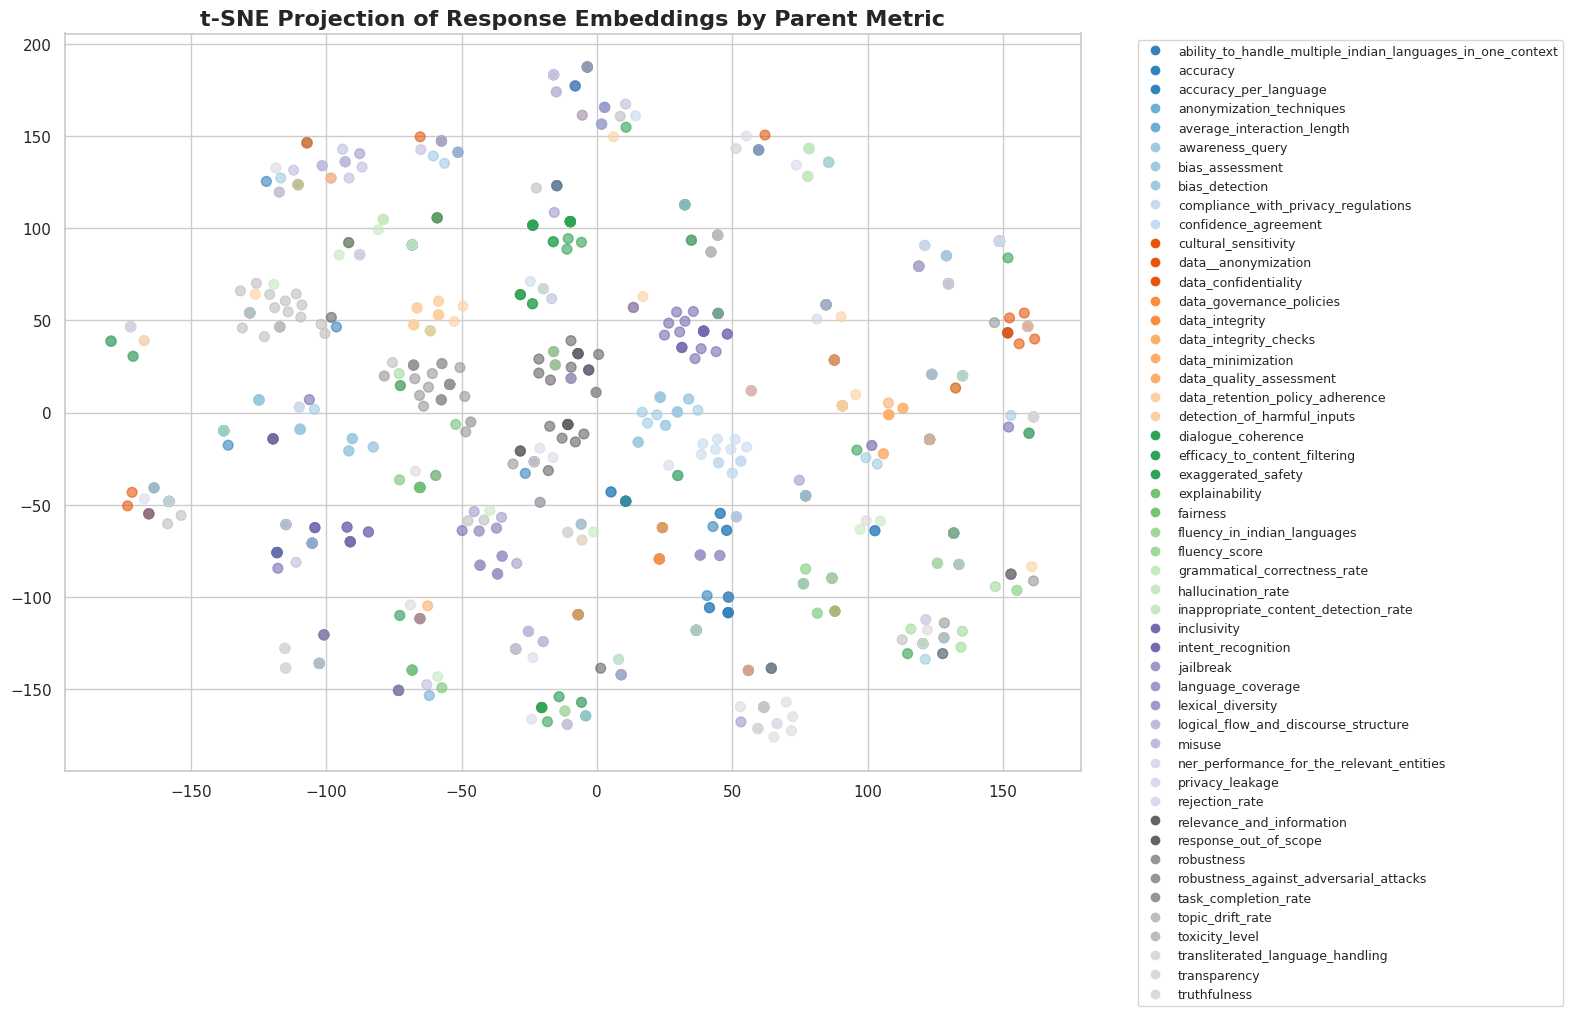

In [18]:
# Ensure train_df_with_parent has a clean integer positional index for iloc
train_df_with_parent = train_df_with_parent.reset_index(drop=True)

train_parent = train_df_with_parent['parent_metric'].values
n_train = len(train_parent)
n_total = X_final.shape[0]

print(f"n_train={n_train}, n_total(X_final)={n_total}, len(idx_val)={len(idx_val)}")

# Create an array to hold parent metric for every row in the embedding matrix
parent_metrics_all = np.empty(n_total, dtype=object)
parent_metrics_all[:] = np.nan  # default

parent_metrics_all[:n_train] = train_parent

for j in range(n_train, n_total):
    orig_idx = j - n_train
    if 0 <= orig_idx < n_train:
        parent_metrics_all[j] = train_parent[orig_idx]
    else:
        parent_metrics_all[j] = np.nan


idx_val_array = np.array(idx_val, dtype=int)
val_parent_metrics = parent_metrics_all[idx_val_array]

print("Generating t-SNE visualization colored by Parent Metric")

subset_size = min(2000, len(idx_val_array))
if subset_size == 0:
    raise ValueError("idx_val is empty — nothing to visualize.")

# when len(idx_val_array) == subset_size, set replace=False is fine; otherwise sample w/o replacement
replace_flag = subset_size > len(idx_val_array)
subset_idx_local = np.random.choice(len(idx_val_array), size=subset_size, replace=replace_flag)

# Build vectors and metric subset
vec_subset = X_final[idx_val_array[subset_idx_local], :768]
parent_subset = val_parent_metrics[subset_idx_local]

valid_mask = ~pd.isna(parent_subset)
vec_subset = vec_subset[valid_mask]
parent_subset = parent_subset[valid_mask]

# PCA then t-SNE
pca_result = PCA(n_components=min(50, vec_subset.shape[1])).fit_transform(vec_subset)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

plt.figure(figsize=(16, 10))
unique_metrics = np.unique(parent_subset)
# map metrics to int colors
metric_to_int = {m: i for i, m in enumerate(unique_metrics)}
ints = np.array([metric_to_int[m] for m in parent_subset])

# Use scatter with numeric colormap
sc = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=ints, cmap='tab20c', alpha=0.6, s=50)
plt.title("t-SNE Projection of Response Embeddings by Parent Metric", fontsize=16, fontweight='bold')

# Build legend manually
handles = []
labels = []
for m, i in metric_to_int.items():
    handles.append(plt.Line2D([], [], marker="o", linestyle="", markersize=6, color=plt.cm.tab20c(i / max(1, len(unique_metrics)-1))))
    labels.append(str(m))
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

A lot of nice clusters are visualised in the entire space, some of them are pure also with minimal overlap. Distinct clusters are observed. 